# Prerequisites for ```binder``` execution

If you are runnning on ```binder``` you will be needing to install following python packages to excute data processing:

```numpy pandas matplotlib```

Therefore, be sure to execute the following cell every time you start a new ```binder``` session.

In [9]:
import sys
import subprocess

# Run pip install quietly
subprocess.run(
    [sys.executable, "-m", "pip", "install", "numpy", "pandas", "matplotlib"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL,
    check=True
)

print("Prerequisites installed successfully. Go on for data process.")

Prerequisites installed successfully. Go on for data process.


# Data process demonstration

Next we demonstrate the data processing of cosmic ray measurement. 

In the measurement, oscilloscope data is saved in binary files. Each measurement saves the data of all 4 channels. 

The data file name is in the format of ```run[measurement_number]_[channel number].isf```. Examples of data are provided in ```../data/sample```

To measure the speed of cosmicray, the binary data needs to be decoded and analyzed properly. A helper package ```cosmicray``` is prepared to simplify the analysis. In this package, several helper functions are pre-defined:

```decode_isf_to_csv(isf_filename: str, TIME_OFFSET: float, baseline_points: int = 1000, saturation_threshold: int = 32700)``` accepts a single ```.isf``` data file and decodes it, translating binary data into ```.csv``` file. It returns ```(waveform_amplitude, first_fwhm_timing, saturation_flag, csv_file_path)```.

```plot_waveforms_csv(csv_files, labels=None, title=None, xlim=None, ylim=None, voltage_unit="V", time_unit="ns", savepath=None, show=True)``` accepts a list of translated ```.csv``` files and make proper plots to inspect the measured waveforms.

```process_data( dir_data: str, n_measurements: int, TIME_OFFSET: float, calibrations: List[float] = [0, 0, 0, 0], summary_name: str = "summary.csv")``` accepts data directory, number of measurements to process and calibration information to process data massively, returning a path to the summary file, including waveform amplitudes, FWHM timing, calibrated FWHM timing and CSV files for all 4 channels in each measurement.

Before going to data processing, we import necessary packages.

In [1]:
import numpy as np
import pandas as pd
import cosmicray as cr
import matplotlib.pyplot as plt

## Process single measurement

Here we demonstrate how a single measurement is analyzed.

A single measurement contains data of all 4 channels, so basically we need to iterate through 4 channels and decode them one by one using ```decode_isf_to_csv```. Remember to save the necessary information output from the decode function.

In [5]:
vmins = [] # V
fwhms = []
saturations = []
csvs = []
TIME_OFFSET = 950 # ns

for i in range(4):
    vmin, fwhm, saturation, csv = cr.decode_isf_to_csv(f"../data/sample/run00115_{i+1}.isf", TIME_OFFSET)
    vmins.append(vmin)
    fwhms.append(fwhm)
    saturations.append(saturation)
    csvs.append(csv)

    if saturation == 1:
        print("saturation?")

print(f"wave form amplitudes for channle 1, 2, 3, 4 (V): {vmins}")
print(f"fwhm timing for channle 1, 2, 3, 4 (ns): {fwhms}")

wave form amplitudes for channle 1, 2, 3, 4 (V): [-0.5439142968749999, -0.5282984375, -0.33836078125, -0.2719848437499999]
fwhm timing for channle 1, 2, 3, 4 (ns): [9.768422424242486, 9.27295890410965, 8.813161951219577, 10.148575769230803]


After the decoding, corresponding translated ```.csv``` files are generated. We can have a simple look using ```pandas```. 

In [3]:
df=pd.read_csv(csvs[0])
df.head()

,time_ns,voltage_V
0,-950.0,-0.013836
1,-949.8,0.008508
2,-949.6,0.006945
3,-949.4,0.018117
4,-949.2,0.006633


Based on the translated ```.csv``` files, waveforms can be plotted using ```plot_waveforms_csv``` for inspectation.

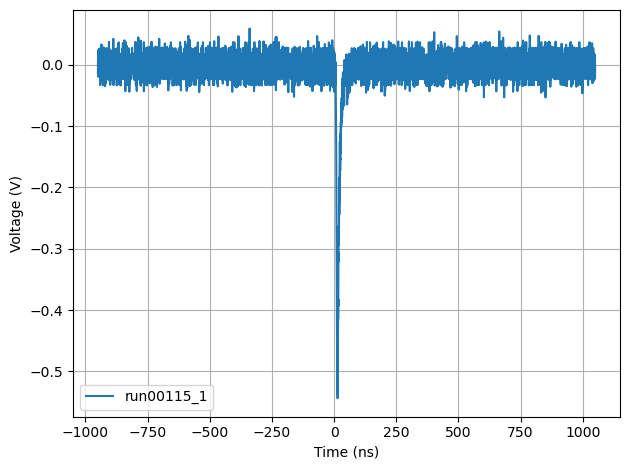

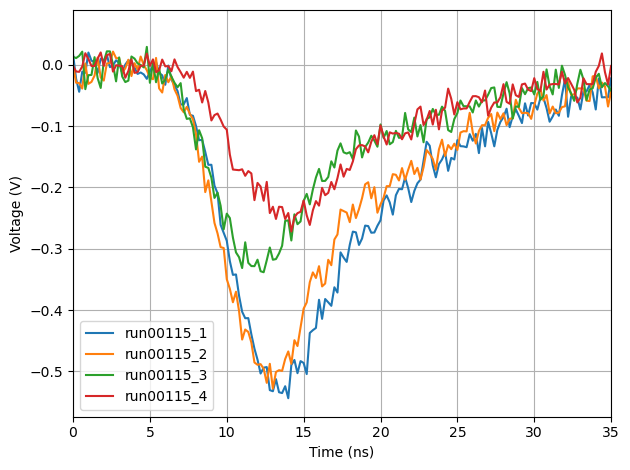

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Time (ns)', ylabel='Voltage (V)'>)

In [4]:
cr.plot_waveforms_csv([csvs[0]])
cr.plot_waveforms_csv(csvs,xlim=(-0,35))

## Process multiple measurement

To process multiple data, we utilize ```process_data``` function. Here we need to input the directory where the data is saved and the number of measurements to be processed. Calibration information is specified as ```[d_t1, d_t2, d_t3, d_t4]```, which are added to the corresponding fwhm timings directly.



In [7]:
# firstly we need to decode the data from all measurement and save the timing informations
n_measurements = 417
dir_data = "../data/sample"
# no calibration yet
calibrations = [0, 0, 0, 0]
TIME_OFFSET = 950 # ns

summary_file = cr.process_data(dir_data,n_measurements,TIME_OFFSET,calibrations,"summary.csv")

Summary saved to: ../data/sample/summary.csv


After the processing, we can have a look into the summary ```.csv``` file.

In [8]:
df=pd.read_csv(summary_file)
df.head()

,measurement,v1,v2,v3,v4,t1,t2,t3,t4,ct1,ct2,ct3,ct4,csv1,csv2,csv3,csv4
0,0,-0.255304,-0.250909,-0.603670,-0.526010,9.955646,8.184478,8.078661,9.631898,9.955646,8.184478,8.078661,9.631898,../data/sample/run00000_1.csv,../data/sample/run00000_2.csv,../data/sample/run00000_3.csv,../data/sample/run00000_4.csv
1,1,-0.353595,-0.341451,-0.622175,-0.622432,10.334665,9.248754,9.486529,9.911553,10.334665,9.248754,9.486529,9.911553,../data/sample/run00001_1.csv,../data/sample/run00001_2.csv,../data/sample/run00001_3.csv,../data/sample/run00001_4.csv
2,2,-0.257400,-0.261140,-0.901757,-0.833387,10.073603,9.655841,9.148840,10.329899,10.073603,9.655841,9.148840,10.329899,../data/sample/run00002_1.csv,../data/sample/run00002_2.csv,../data/sample/run00002_3.csv,../data/sample/run00002_4.csv
3,3,-0.392175,-0.278222,-0.549665,-0.493209,10.631155,9.598010,9.709278,10.220150,10.631155,9.598010,9.709278,10.220150,../data/sample/run00003_1.csv,../data/sample/run00003_2.csv,../data/sample/run00003_3.csv,../data/sample/run00003_4.csv
4,4,-0.285378,-0.282701,-0.190615,-0.223834,10.078790,8.892909,8.711479,9.505930,10.078790,8.892909,8.711479,9.505930,../data/sample/run00004_1.csv,../data/sample/run00004_2.csv,../data/sample/run00004_3.csv,../data/sample/run00004_4.csv


## Time of flight

For each measurement we can calculate the desired time-of-flight (TOF) of the cosmic ray.

Using ```pandas``` we can calculate (TOF) for each measurement directly from the summary ```.csv``` file and inspect by plotting histogram of it.

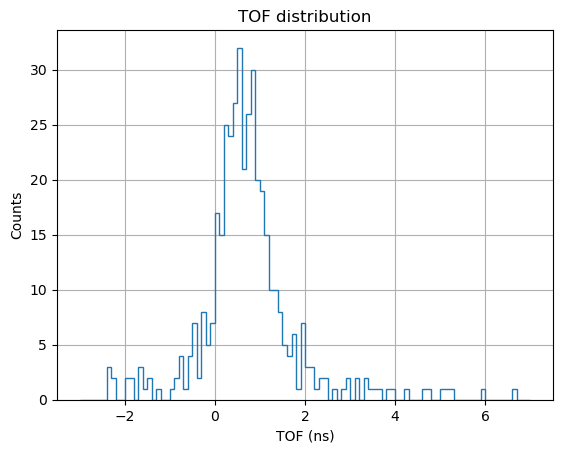

In [7]:
# calculate the tof, plot histogram and do fitting
df=pd.read_csv(summary_file)
tof = (df["t1"] + df["t4"] - df["t3"] - df["t2"]) / 2

plt.figure()
counts, bins, _ = plt.hist(
    tof,
    bins=100,
    range=(-3, 7),   # <<< set your range here
    histtype="step"
)

plt.xlabel("TOF (ns)")
plt.ylabel("Counts")
plt.title("TOF distribution")
plt.grid(True)
plt.show()